In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading in the data
#gfr = pd.read_excel("df_capstone_query01.xlsx")
gfr_opdates = pd.read_csv("gfr_opdates.csv")
gfr_opdates=gfr_opdates.drop(columns=['Unnamed: 0'])
path_date=pd.read_csv("nephrectomies_w_dates_from_path.csv")
op_note=pd.read_csv('op_note_dates.csv')
op_note=op_note.drop(columns=['Unnamed: 0'])

In [3]:
print(f"Number of total patients - initial cohort: {gfr_opdates.pat_id.nunique()}")

Number of total patients - initial cohort: 2915


## Filter to eligible GFRs

### Exclude age<18:

In [4]:
def calculate_age(birth_date, surgery_date):
    age = surgery_date.year - birth_date.year - ((surgery_date.month, surgery_date.day) < (birth_date.month, birth_date.day))
    return age

In [5]:
gfr_opdates['surgery_date_op_conv'] = pd.to_datetime(gfr_opdates['surgery_date_op'], errors='coerce')
gfr_opdates['birth_date_conv'] = pd.to_datetime(gfr_opdates['birth_date'], errors='coerce')

gfr_opdates['age'] = gfr_opdates.apply(lambda row: calculate_age(row['birth_date_conv'], row['surgery_date_op_conv']), axis=1)
gfr_opdates_18 = gfr_opdates[gfr_opdates.age>=18]
pat_excl18=gfr_opdates['pat_id'].nunique() - gfr_opdates_18['pat_id'].nunique()
print(f"{pat_excl18} pat_id excluded from dataframe gfr_opdates, {gfr_opdates_18['pat_id'].nunique()} left.")

33 pat_id excluded from dataframe gfr_opdates, 2882 left.


**Exclude from path_date**

Add surgery_date_op to path_date

In [6]:
path_op = path_date.merge(op_note, on=['pat_id', 'surgery_date', 'procedure_name'], how='left')
path_op = path_op.drop(columns=['mrn_y', 'birth_date_y','pat_last_name_y', 'sex_y', 'ethnicity_y', 'race_y', 'living_status_y',
       'death_date_y',  'proc_id_y','performed_y'])
path_op.columns =path_op.columns.str.replace('_x$', '', regex=True)

In [7]:
path_op['surgery_date_op_conv'] = pd.to_datetime(path_op['surgery_date_op'], errors='coerce')
path_op['surgery_date_conv']=  pd.to_datetime(path_op['surgery_date'], format='%Y%m%d', errors='coerce')
path_op['birth_date'] = pd.to_datetime(path_op['birth_date'], errors='coerce')

#fill in path surgery_date_op_conv if available, surgery_date if not
path_op['surgery_date_op_conv']=np.where(path_op['surgery_date_op_conv'].notna(), path_op['surgery_date_op_conv'], path_op['surgery_date_conv'])

path_op['age'] = path_op.apply(lambda row: calculate_age(row['birth_date'], row['surgery_date_op_conv']), axis=1)
path_op18 = path_op[path_op.age>=18]
pat_excl18_path=path_op['pat_id'].nunique() - path_op18['pat_id'].nunique()
print(f'Given {path_op.pat_id.nunique()} pat_ids from path_op')
print(f"{pat_excl18_path} pat_id excluded from dataframe path_op, left with {path_op18['pat_id'].nunique()} pat_ids.")

Given 1461 pat_ids from path_op
23 pat_id excluded from dataframe path_op, left with 1438 pat_ids.


### Filter path_date_18 to gross description and clinical history with 'surgery_date_from_path' within 31 days of surgery_date

In [8]:
path_op18 = path_op18[~path_op18['external_name'].str.contains("Disclaimer", case=False)]
path_op18['surgery_date_from_path_conv'] = pd.to_datetime(path_op18['surgery_date_from_path'], errors='coerce')
path_op18['days_diff'] = (path_op18['surgery_date_from_path_conv'] - path_op18['surgery_date_op_conv']).dt.days
path_date_sub = path_op18[abs(path_op18['days_diff']) <= 31]
excl_path_date=path_op18.pat_id.nunique() - path_date_sub.pat_id.nunique() 
print(f'{excl_path_date} pat_id excluded, left with {path_date_sub.pat_id.nunique()} pat_ids')

345 pat_id excluded, left with 1093 pat_ids


LEAVE OUT FOR NOW

**<span style="background-color: lightgreen">Since the value of the path report description does not indicate procedure was not performed, we will not filter out performed=0 at this stage but rather rely on classification of PN/RN from path notes.**

In [9]:
print(f"Path reports were reduced from {path_date.pat_id.nunique()} to {path_date_sub.pat_id.nunique()} patients")

Path reports were reduced from 1461 to 1093 patients


### Subset gfr_18 to have the same set of [pat_id, mrn, proc_id, procedure_name, surgery_date] in path_date_sub

In [10]:
gfr_sub_path=path_date_sub.merge(gfr_opdates_18, on = ['pat_id', 'mrn', 'proc_id','procedure_name','surgery_date'], how = 'left')
#drop dup columns
gfr_sub_path=gfr_sub_path.drop(columns = ['pat_last_name_y', 'sex_y', 'ethnicity_y', 'race_y', 'living_status_y', 'death_date_y', 'age_y', 'birth_date_y'])
#delete _x in column names
gfr_sub_path.columns = gfr_sub_path.columns.str.replace('_x$', '', regex=True)

In [11]:
print(f"Number of patients after subsetting >18yo patients to path reports <=31 days from surgery date: {gfr_sub_path.pat_id.nunique()} ")

Number of patients after subsetting >18yo patients to path reports <=31 days from surgery date: 1093 


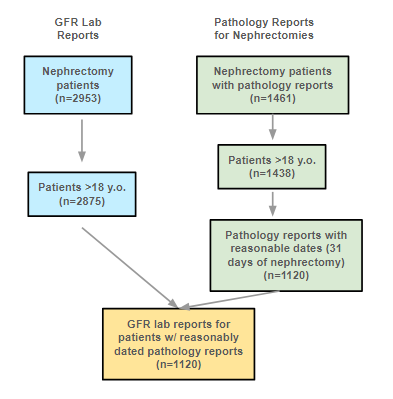

In [12]:
#drop duplicate columns
gfr_sub_path=gfr_sub_path.drop(columns=gfr_sub_path.filter(like='_y').columns)
#gfr_sub_path.to_csv("gfr_path_cohort.csv")

### Designate pre and post creatinines for each patient-surgery 
#### Pre: closest before (but not on day of) surgery
#### Post: latest result within 2 weeks

**Creatinine**

In [14]:
#gfr_sub_path=pd.read_csv('gfr_path_cohort.csv')
creat=pd.read_excel("df_capstone_nephrect_creat.xlsx")

In [15]:
#subset to pat_ids in gfr_sub_path and where component_name=CREATININE   
gfr_pats=list(gfr_sub_path.pat_id.value_counts().index)
creat_sub=creat[(creat.pat_id.isin(gfr_pats)) &(creat.component_name=='CREATININE')]

#convert to datatime for merge consistensy
creat_sub['birth_date_conv']=pd.to_datetime(creat_sub['birth_date'], errors='coerce')
creat_sub['surgery_date_conv']=pd.to_datetime(creat_sub['surgery_date'], errors='coerce')

gfr_sub_path['surgery_date_conv']=pd.to_datetime(gfr_sub_path['surgery_date'], errors='coerce')

In [16]:
print(f"{creat_sub.pat_id.nunique()} patients in the gfr cohort (with valid path report) have CREATININE values")

1053 patients in the gfr cohort (with valid path report) have CREATININE values


Get op_date from gfr_sub_path

In [17]:
creat_opdate = creat_sub.merge(gfr_sub_path[['pat_id', 'surgery_date_conv', 'surgery_date_op_conv','procedure_name']],
                                              on=['pat_id','surgery_date_conv', 'procedure_name'], how='left')
creat_opdate=creat_opdate.drop_duplicates(subset=['pat_id', 'surgery_date_conv', 'surgery_date_op_conv','component_name','result_time','procedure_name'])

**Calculate days_diff between result_time (creatinine) and surgery_date_op** 

In [18]:
#creat_ = creat_opdate.copy()
creat_opdate['result_time_conv'] = pd.to_datetime(creat_opdate['result_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
creat_opdate['days_diff'] = (creat_opdate['result_time_conv'] - creat_opdate['surgery_date_op_conv']).dt.days
#creat_opdate = creat_opdate[(abs(creat_opdate['days_diff']) <= 31)]# & (abs(creat_opdate['days_diff']) != 0)]

**Assign preop**

In [19]:
creat_opdate = creat_opdate.dropna(subset=['days_diff'])
creat_opdate['preop']=0
# Filter the DataFrame for negative 'days_diff' values
negative_days_diff = creat_opdate[creat_opdate['days_diff'] < 0]

# Find the maximum 'days_diff' value within each group that is negative
max_negative_days_diff = negative_days_diff.groupby(['pat_id', 'procedure_name', 'surgery_date_op_conv'])['days_diff'].max()

# Convert the Series to a DataFrame to merge with the original DataFrame
max_negative_days_diff_creat_opdate = max_negative_days_diff.reset_index()
max_negative_days_diff_creat_opdate.rename(columns={'days_diff': 'max_days_diff'}, inplace=True)

# Merge the maximum negative 'days_diff' values with the original DataFrame
creat_opdate = creat_opdate.merge(max_negative_days_diff_creat_opdate, on=['pat_id', 'procedure_name', 'surgery_date_op_conv'], how='left')

# Assign 1 to 'preop' where 'days_diff' is equal to the maximum negative 'days_diff' within its group
creat_opdate['preop'] = (creat_opdate['days_diff'] == creat_opdate['max_days_diff']).astype(int)

# Sort the DataFrame by 'result_time_conv' in descending order so the latest dates come first
creat_opdate = creat_opdate.sort_values(by='result_time_conv', ascending=False)

# Drop duplicates, keeping only the first entry (which is the latest due to the sorting) for each group
creat_opdate = creat_opdate.drop_duplicates(subset=['pat_id', 'procedure_name', 'surgery_date_op_conv','days_diff', 'preop'], keep='first')

In [20]:
print(f"{len(creat_opdate[(creat_opdate.preop==1) & (creat_opdate.days_diff<-93)])} records, {creat_opdate[(creat_opdate.preop==1) & (creat_opdate.days_diff<-93)].pat_id.nunique()} pat_ids have preop creatinine before 93 days before surgery.") 

47 records, 44 pat_ids have preop creatinine before 93 days before surgery.


Exclude

In [21]:
creat_opdate_preop_recent=creat_opdate[creat_opdate.days_diff>=-93]

In [22]:
creat_opdate_preop_recent.pat_id.nunique()

1039

**Assign postop: within 2 weeks**

In [23]:
def assign_post(df, min_days, max_days):
    df= df.copy()
    postop_range = df[(df['days_diff'] >= min_days) & (df['days_diff'] <= max_days)]

    #within postop_range, find maximum result_time_conv for every [pat_id, procedure_name, surgery_date_from_path_] combo
    max_result_time = postop_range.groupby(['pat_id', 'surgery_date_op_conv', 'procedure_name'])['result_time_conv'].max()

    # Convert the Series to a DataFrame to merge with the original DataFrame
    max_result_time = max_result_time.reset_index()
    max_result_time.rename(columns={'result_time_conv': 'max_result_time'}, inplace=True)

    df = df.merge(max_result_time, on=['pat_id', 'procedure_name', 'surgery_date_op_conv'], how='left')

    # Assign 1 to 'preop' where 'days_diff' is equal to the maximum negative 'days_diff' within its group
    df['postop'] = (df['result_time_conv'] == df['max_result_time']).astype(int)
    return df

**Explore post-off cutoffs: match on pat_id, surgery_date, procedure_name, component_name (type of lab)** <br>


In [24]:
def pat_ids_avails(df, min_days, max_days):
    print(f"between {min_days} days and {max_days} days postop:")
    prepost_all = assign_post(df, min_days, max_days)
    prepost_either = prepost_all[(prepost_all.preop==1)|(prepost_all.postop==1)]
    print(f"{prepost_either.pat_id.nunique()} patients have either pre or postop creatinine")
    
    prepost_cnt=prepost_either.groupby(['pat_id', 'surgery_date_op_conv', 'procedure_name', 'component_name'])['preop', 'postop'].sum()
    prepost_cnt.rename(columns={'preop': 'sum_preop', 'postop': 'sum_postop'}, inplace=True)
    prepost_cnt=prepost_cnt.reset_index()
    ids_both = prepost_cnt[(prepost_cnt.sum_preop!=0) & (prepost_cnt.sum_postop!=0)].pat_id.nunique()
    print(f"{ids_both} patients have creatinines both pre and post-op")
    return 

In [25]:
pat_ids_avails(creat_opdate_preop_recent, 1, 17) #within two week, count surgery_date_op creatinine as postop

between 1 days and 17 days postop:
1033 patients have either pre or postop creatinine
844 patients have creatinines both pre and post-op


### Match pre and postop

Assign age

In [27]:
prepost_all= assign_post(creat_opdate_preop_recent, 1, 17) #parameterize 
prepost_all['age'] = prepost_all.apply(lambda row: calculate_age(row['birth_date_conv'], row['surgery_date_op_conv']), axis=1)
prepost_either = prepost_all[(prepost_all.preop==1)|(prepost_all.postop==1)]
prepost_cnt=prepost_either.groupby(['pat_id', 'age','sex','race','surgery_date_op_conv', 'procedure_name'])['preop', 'postop'].sum()
prepost_cnt.rename(columns={'preop': 'sum_preop', 'postop': 'sum_postop'}, inplace=True)
prepost_cnt=prepost_cnt.reset_index()
miss_pre_or_post = prepost_cnt[(prepost_cnt.sum_preop==0) | (prepost_cnt.sum_postop==0)]
#display(miss_pre_or_post)
print(f"{miss_pre_or_post.pat_id.nunique()} patients are missing either pre or post creatinine")

196 patients are missing either pre or post creatinine


**Exclude the [pat_id, surgery_date, procedure_name] combinations (196 patients) from prepost_all**

In [28]:
def filterout_df(df_to_filter, df_filter, keys):
    # Perform a left join and keep only the records from df_to_filter that don't have a match in df_filter
    filtered_df = pd.merge(df_to_filter, df_filter, on=keys, how='left', indicator=True)
    filtered_df = filtered_df[filtered_df['_merge'] == 'left_only']
    return filtered_df.drop(columns=['_merge'])

# Define the keys for filtering
keys = ['pat_id', 'surgery_date_op_conv', 'procedure_name']

# Use the function to filter the DataFrame
creat_both = filterout_df(prepost_either, miss_pre_or_post, keys)
#drop dupe columns and rows
cols=['pat_id','surgery_date_op_conv','procedure_name','result_time_conv','days_diff','component_name',
      'raw_value', 'preop', 'postop']
creat_both=creat_both.drop_duplicates(subset=cols)
creat_both=creat_both.drop(columns=creat_both.filter(like='_y').columns)
creat_both.columns=creat_both.columns.str.replace('_x', '')

print(f"{creat_both.pat_id.nunique()} patients have no missing pre and post GFRs. Reduced from {prepost_either.pat_id.nunique()} patients with either pre or post GFR")

844 patients have no missing pre and post GFRs. Reduced from 1033 patients with either pre or post GFR


**2. Further handle gfr_both: records with valid GFRs both pre and postop**

**2a. Subset the ['pat_id, 'surgery_date_conv', 'procedure_name'] that match on component_name**, like first two rows below:

In [29]:
#temp=2 means matching component names from pre and post op, since this subset starts with patients with both pre and postop GFRs
creat_both['temp']=creat_both['preop']+creat_both['postop']
match_comp=creat_both.groupby(['pat_id','surgery_date_op_conv','age','sex','race','procedure_name','component_name'])['temp'].sum().reset_index()
match_comp.rename(columns={'temp':'sum_temp'}, inplace=True)

#pat_id, surgery_date, procedure_name and *component_name* with both pre and post GFRs (same type)
same_comp_name=match_comp[match_comp.sum_temp==2]

#create a subset by matching on [pat_id, surgery_date] combo
creat_comp_match = creat_both.merge(same_comp_name, on=['pat_id','surgery_date_op_conv','procedure_name','component_name'], how='inner') #keys=['pat_id', 'surgery_date_op_conv', 'procedure_name']
creat_comp_match.columns=creat_comp_match.columns.str.replace('_x', '')
print(f"Create subset from creat_both: {creat_comp_match.pat_id.nunique()} pat_ids with same type of pre and post GFRs")

Create subset from creat_both: 844 pat_ids with same type of pre and post GFRs


In [30]:
creat_comp_match['pre_creat']=np.where(creat_comp_match['preop']==1, creat_comp_match['raw_value'],np.nan)
creat_comp_match['post_creat']=np.where(creat_comp_match['postop']==1, creat_comp_match['raw_value'],np.nan)

grouped_creat = creat_comp_match.groupby(['pat_id', 'age','sex','race','surgery_date_op_conv', 'procedure_name', 'component_name'], as_index=False)
creat_final = grouped_creat.agg({
    'pre_creat': 'first',
    'post_creat': 'first'})

#convert to numeric to and drop nonnumeric values
creat_final['pre_creat']=pd.to_numeric(creat_final['pre_creat'], errors = 'coerce')
creat_final['post_creat']=pd.to_numeric(creat_final['post_creat'], errors = 'coerce')

creat_final = creat_final.dropna(subset=['pre_creat'])
creat_final = creat_final.dropna(subset=['post_creat'])

In [31]:
print(f"{creat_final.pat_id.nunique()} pat_ids with pre and post creatinine")
#display(creat_final)

843 pat_ids with pre and post creatinine


Export

In [ ]:
creat_final.to_csv("creat_final_cohort.csv")